In [2]:
def fill_na(df, year_pop_stat, rooms_pop_stat: int, floor_pop_stat: int):

    df['year'] = df['year'].fillna(year_pop_stat)
    df['rooms'] = df['rooms'].fillna(rooms_pop_stat)
    df['floor'] = df['floor'].fillna(floor_pop_stat)

    df['area_outside'] = df['area_outside'].fillna(0)
    df['rent'] = df['rent'].fillna(0)

    df['free_month'] = df['free_month'].fillna(df['upload_month'])
    df['free_year'] = df['free_year'].fillna(df['upload_year'])

    return df

In [4]:
from pandas import read_csv
df = read_csv('dataset.reduced.bin.csv', index_col=0, low_memory=False)
#df = read_csv('/kaggle/input/otodomdata/dataset.reduced.bin.csv', index_col=0, low_memory=False)

X = df.drop('price', axis=1)
y = df['price']

from sklearn.model_selection import train_test_split  # żeby uniknąc przecieku mediany
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X = fill_na(X, X['year'].median(), X['rooms'].median(), X['floor'].median())

del df

from ydata_profiling import ProfileReport
ProfileReport(X, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

model = BaggingRegressor(estimator=DecisionTreeRegressor())
scores = cross_val_score(model, X, y, cv=5)

model.fit(X, y)

In [20]:
from pandas import DataFrame
from numpy import array

X_test = fill_na(X_test, X['year'].median(), X['rooms'].median(), X['floor'].median())
pred = DataFrame({ 
    'y': [*y, *y_test], 
    'pred': [*model.predict(X), *model.predict(X_test)], 
    'test': array([0] * len(X) + [1] * len(X_test)) 
})

pred_no_outl = pred[pred['y'] < pred['y'].quantile(0.90)]
lim = (0, max(*pred_no_outl['y'], *pred_no_outl['pred']))

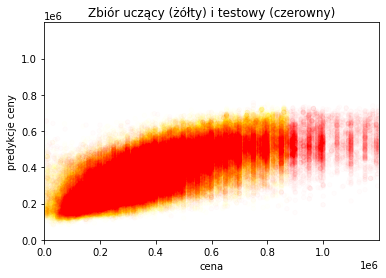

In [21]:
pred_no_outl.plot(kind='scatter', x='y', y='pred', alpha=.01, xlim=lim, ylim=lim,
    c=pred_no_outl['test'].map({0: 'yellow', 1: 'red'}), 
    title="Zbiór uczący (żółty) i testowy (czerowny)", ylabel='predykcje ceny', xlabel='cena');


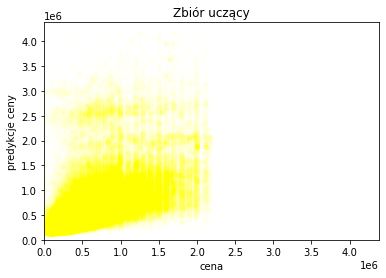

In [20]:
pred_no_outl.loc[pred['test'] == 0].plot(kind='scatter', x='y', y='pred', alpha=.01, xlim=lim, ylim=lim, c='yellow',
    title='Zbiór uczący', ylabel='predykcje ceny', xlabel='cena');

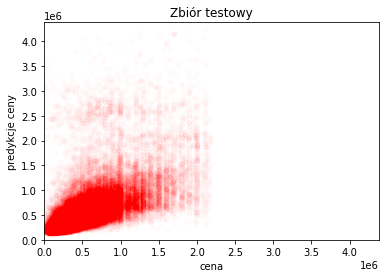

In [21]:
pred_no_outl.loc[pred['test'] == 1].plot(kind='scatter', x='y', y='pred', alpha=.01, c='red', xlim=lim, ylim=lim,
    title='Zbiór testowy', ylabel='predykcje ceny', xlabel='cena');

In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from numpy import mean, abs

DataFrame({
    'R2': [r2_score(pred['y'], pred['pred'])],
    'MSE': [mean_squared_error(pred['y'], pred['pred'])],
    'MAPE': [mean(abs((pred['y'] - pred['pred']) / pred['y'])) * 100],
    'MAE': mean_absolute_error(pred['y'], pred['pred'])
}, index=['stat'])

,R2,MSE,MAPE
stat,0.01306,1.661186e+12,30.48435
